In this example we learn about the relative drift importances that results in model drift. Here we use the model explainiabilty aspect of ML, available in CinnaMon library and its ModelDriftExplainer functionality.

The experiment is done with a random split so we should not detect a data drift. We had run our experiments on California Housing Dataset.

# ModelDrift Explainer on CatBoost ML model

In [1]:
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

from cinnamon.drift import ModelDriftExplainer

/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# California Housing Data

In [2]:
from sklearn.datasets import fetch_california_housing

from sklearn.datasets import fetch_openml
california = fetch_openml(name="house_prices", as_frame=True)

california_df = pd.DataFrame(california.data, columns=california.feature_names)
california_df.head(5)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,12,2008,WD,Normal


In [3]:
california_df.shape

(1460, 80)

In [4]:
# checking features
california_cat = california_df.select_dtypes(include='O').keys()
# display variabels
california_cat,california_df.columns

(Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
        'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
        'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
        'SaleType', 'SaleCondition'],
       dtype='object'),
 Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
        'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
        'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
        'RoofStyle',

In [5]:
# creating new df
# setting columns we use
new_df = california_df[california_cat]
new_df.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


In [6]:
# unique values in each columns
for x in new_df.columns:
    #prinfting unique values
    print(x ,':', len(new_df[x].unique()))

MSZoning : 5
Street : 2
Alley : 3
LotShape : 4
LandContour : 4
Utilities : 2
LotConfig : 5
LandSlope : 3
Neighborhood : 25
Condition1 : 9
Condition2 : 8
BldgType : 5
HouseStyle : 8
RoofStyle : 6
RoofMatl : 8
Exterior1st : 15
Exterior2nd : 16
MasVnrType : 5
ExterQual : 4
ExterCond : 5
Foundation : 6
BsmtQual : 5
BsmtCond : 5
BsmtExposure : 5
BsmtFinType1 : 7
BsmtFinType2 : 7
Heating : 6
HeatingQC : 5
CentralAir : 2
Electrical : 6
KitchenQual : 4
Functional : 7
FireplaceQu : 6
GarageType : 7
GarageFinish : 4
GarageQual : 6
GarageCond : 6
PavedDrive : 3
PoolQC : 4
Fence : 5
MiscFeature : 5
SaleType : 9
SaleCondition : 6


In [7]:
# for all categorical variables we selected
import numpy as np
def top_x(df2,feature_list):
    
    for featr in feature_list:
        #df2[featr].value_counts().sort_values(ascending=False).head(20)
        top_x_labels = [x for x in df2[featr].value_counts().sort_values(ascending=False).head(20).index]
        for label in top_x_labels:
            df2[featr+'_'+label] = np.where(df2[featr]==label,1,0)
            # read the data again
            #data = california_df[california_cat]
    return df2
        

#encode Nighborhood into the 10 most frequent categories
data = top_x(california_df,list(california_cat))
california_n_cat = data.select_dtypes(include='O').keys()
print(len(data.columns), len(california_df.columns), len(california_n_cat))


data = data.drop(columns = list(california_cat))
# display data
data.head()


327 327 43


<ipython-input-7-59bd48f9c89f>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[featr+'_'+label] = np.where(df2[featr]==label,1,0)
<ipython-input-7-59bd48f9c89f>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[featr+'_'+label] = np.where(df2[featr]==label,1,0)
<ipython-input-7-59bd48f9c89f>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_CWD,SaleType_Oth,SaleType_Con,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Alloca,SaleCondition_AdjLand
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,0,1,0,0,0,0,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,1,0,0,0,0,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,0,1,0,0,0,0,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,0,0,0,1,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,0,1,0,0,0,0,0


In [8]:
feature_names = data.columns[1:]
california.target, feature_names

(0       208500
 1       181500
 2       223500
 3       140000
 4       250000
          ...  
 1455    175000
 1456    210000
 1457    266500
 1458    142125
 1459    147500
 Name: SalePrice, Length: 1460, dtype: int64,
 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
        ...
        'SaleType_ConLw', 'SaleType_CWD', 'SaleType_Oth', 'SaleType_Con',
        'SaleCondition_Normal', 'SaleCondition_Partial',
        'SaleCondition_Abnorml', 'SaleCondition_Family', 'SaleCondition_Alloca',
        'SaleCondition_AdjLand'],
       dtype='object', length=283))

# Build CatBoost model

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, california.target, test_size=0.3, random_state=2021)

In [10]:
model = CatBoostRegressor(loss_function='RMSE',
                         learning_rate=0.1,
                         iterations=1000,
                         max_depth=6,
                         early_stopping_rounds=20,
                         random_seed=2021,
                         verbose=10
                       )

In [11]:
model.fit(X=X_train, y=y_train, eval_set=[(X_test, y_test)])

/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py:1222: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


0:	learn: 75488.3563699	test: 72838.3938478	best: 72838.3938478 (0)	total: 54ms	remaining: 53.9s
10:	learn: 44930.5616356	test: 43931.6583755	best: 43931.6583755 (10)	total: 73ms	remaining: 6.56s
20:	learn: 32133.7513387	test: 33368.3984446	best: 33368.3984446 (20)	total: 90.8ms	remaining: 4.23s
30:	learn: 26695.5372326	test: 29142.7561482	best: 29142.7561482 (30)	total: 107ms	remaining: 3.36s
40:	learn: 23528.8094521	test: 27075.5014831	best: 27075.5014831 (40)	total: 124ms	remaining: 2.9s
50:	learn: 21698.9603871	test: 25970.8057400	best: 25970.8057400 (50)	total: 138ms	remaining: 2.57s
60:	learn: 19844.4238929	test: 25313.7386378	best: 25313.7386378 (60)	total: 155ms	remaining: 2.38s
70:	learn: 18788.7474682	test: 24649.5004597	best: 24649.5004597 (70)	total: 168ms	remaining: 2.2s
80:	learn: 17730.1750040	test: 24286.1840636	best: 24286.1840636 (80)	total: 182ms	remaining: 2.07s
90:	learn: 16913.0063933	test: 23944.1776569	best: 23944.1776569 (90)	total: 197ms	remaining: 1.96s
100:	

# Analyze data drift with ModelDriftExplainer

In [12]:
drift_explainer = ModelDriftExplainer(model)
drift_explainer.fit(X1=X_train, X2=X_test, y1=y_train, y2=y_test)

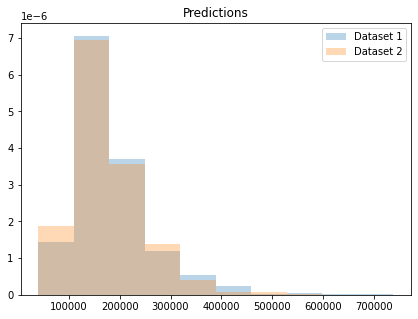

[DriftMetricsNum(mean_difference=-6583.577968753438, wasserstein=6756.960524334862, ks_test=BaseStatisticalTestResult(statistic=0.04142204827136334, pvalue=0.6540811085208531))]

In [13]:
drift_explainer.plot_prediction_drift()
drift_explainer.get_prediction_drift()

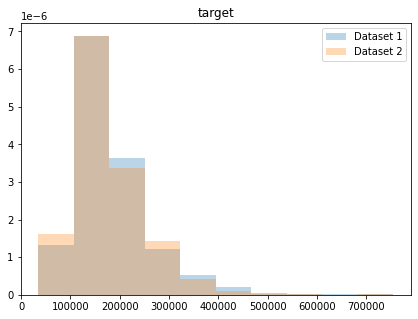

DriftMetricsNum(mean_difference=-5589.04044357469, wasserstein=6036.554468362687, ks_test=BaseStatisticalTestResult(statistic=0.04044357469015003, pvalue=0.6829578717438207))

In [14]:
drift_explainer.plot_target_drift()
drift_explainer.get_target_drift()

In [15]:
drift_explainer.get_performance_metrics_drift()

PerformanceMetricsDrift(dataset1=RegressionMetrics(mse=78341080.29511555, explained_variance=0.9878698131780297), dataset2=RegressionMetrics(mse=519470258.52523524, explained_variance=0.9125880026473956))

/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py:1222: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


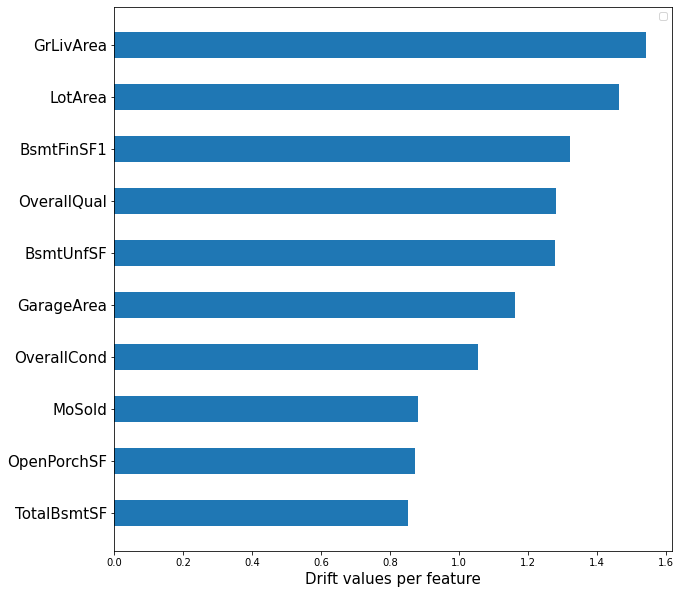

In [16]:
drift_explainer.plot_tree_based_drift_values(type='node_size')

In [17]:
drift_explainer.get_tree_based_drift_values(type='mean')

array([[-6.39647392e+01],
       [-4.78280710e+01],
       [-7.36062182e-01],
       [-2.14880146e+02],
       [-2.02459454e+03],
       [-2.56709705e+02],
       [-3.28679864e+01],
       [ 3.96457261e+01],
       [-1.01549767e+02],
       [-8.14130192e+02],
       [-5.95216285e+01],
       [-3.16116880e+02],
       [-1.63123050e+02],
       [-1.94988762e+02],
       [-1.51676408e+02],
       [ 1.09753846e+00],
       [-8.26720485e+02],
       [-1.68398921e+01],
       [ 7.28572746e+00],
       [ 7.99570734e+01],
       [-3.40185262e+02],
       [ 4.35790088e+01],
       [-8.79348972e+00],
       [ 5.10006155e+01],
       [-8.79064252e+01],
       [-8.84885743e+01],
       [ 5.93249401e+01],
       [-1.35327214e+02],
       [-6.67950833e+01],
       [-1.98414270e+02],
       [ 9.73431157e+00],
       [-1.23358998e+01],
       [ 3.67782887e+01],
       [ 4.54629218e+01],
       [ 5.60073473e-02],
       [ 2.31844661e+01],
       [-6.41522722e+01],
       [ 0.00000000e+00],
       [-6.5

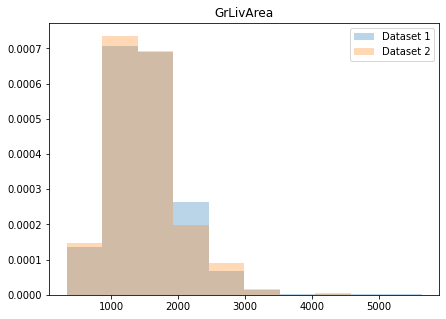

DriftMetricsNum(mean_difference=-677.3701891715591, wasserstein=799.1373124592303, ks_test=BaseStatisticalTestResult(statistic=0.042400521852576645, pvalue=0.6251891675104069))

In [18]:
drift_explainer.plot_feature_drift('GrLivArea')
drift_explainer.get_feature_drift('LotArea')